In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import os

import time
from datetime import timedelta

d:\anaconda3\envs\pytorch\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


#### Batch size
If memory error, reduce the batch_size.

In [2]:
batch_size = 16
num_workers = 0.

#### [ImageFolder](https://github.com/pytorch/vision/blob/master/torchvision/datasets/folder.py)
A generic data loader where the samples are arranged in this way:
```
    root/dog/xxx.png
    root/dog/xxy.png
    root/dog/xxz.png
    root/cat/123.png
    root/cat/nsdf3.png
    root/cat/asd932_.png
    
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
```

In [3]:
# Data loading code
datasetsdir = 'datasets'
traindir = os.path.join(datasetsdir, 'train')
valdir = os.path.join(datasetsdir, 'val')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(traindir, transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((-30, 30)),
        transforms.ToTensor(),
        normalize,
    ])), 
    batch_size=batch_size, shuffle=True,
    num_workers=num_workers)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=False,
    num_workers=num_workers)

classes = [d for d in os.listdir(traindir) if os.path.isdir(os.path.join(traindir, d))]
classes.sort()
print(len(classes))

120


Train + Validation

In [4]:
def train(model, loader, loss_fn, optimizer, num_epochs = 1):
    start_time = time.time()
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        batch_start = time.time()
        for t, (x, y) in enumerate(loader):
            x_var = x.cuda()
            y_var = y.cuda()

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % 100 == 0:
                print('t = %d, loss = %.4f, duration = %s' % (t + 1, loss.item(), timedelta(seconds=time.time() - batch_start)))
                batch_start = time.time()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    print('Duration = %s' % timedelta(seconds=time.time() - start_time))

def check_accuracy(model, loader):
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    start_time = time.time()
    print('Checking accuracy on validation set')
    for x, y in loader:
        with torch.no_grad():
            x_var = x.cuda()

            scores = model(x_var)
            _, preds = scores.data.cpu().max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    print('Duration = %s' % timedelta(seconds=time.time() - start_time))

#### [Pre-trained models](https://pytorch.org/docs/master/torchvision/models.html)

- [VGG16](https://arxiv.org/abs/1409.1556)
- [ResNet](https://arxiv.org/abs/1512.03385)

As always, add one more FC layer or replace the last FC layer with the number of output classes.

In [5]:
def vgg16(pretrained=True):
    model = models.vgg16(pretrained=pretrained)
    def set_untrainable(layer):
        for p in layer.parameters():
            p.requires_grad = False

    for layer in model.children():
        layer.apply(set_untrainable)
    model.classifier = nn.Sequential(*(list(model.classifier.children()) + [nn.ReLU(inplace=True), nn.Linear(1000, 120)]))
    # model.features = torch.nn.DataParallel(model.features)
    model.cuda()
    return model
    
def resnet34(pretrained=True):
    model = models.resnet34(pretrained=pretrained)
    def set_untrainable(layer):
        for p in layer.parameters():
            p.requires_grad = False

    for layer in model.children():
        layer.apply(set_untrainable)
    model.fc = nn.Linear(512, 120)
    model.cuda()
    return model

def resnet50(pretrained=True):
    model = models.resnet50(pretrained=pretrained)
    def set_untrainable(layer):
        for p in layer.parameters():
            p.requires_grad = False

    for layer in model.children():
        layer.apply(set_untrainable)
    model.fc = nn.Sequential(model.fc, nn.Dropout(p=.5), nn.ReLU(inplace=True), nn.Linear(1000, 120))
    model.cuda()
    return model

#### ResNet50

In [17]:
model = resnet34()

loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-3)

train(model, train_loader, loss_fn, optimizer, num_epochs=3)
check_accuracy(model, val_loader)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth
81.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


Starting epoch 1 / 3
t = 100, loss = 3.8267, duration = 0:00:57.306418
t = 200, loss = 3.4604, duration = 0:00:41.169967
t = 300, loss = 2.9490, duration = 0:00:38.517835
t = 400, loss = 2.5956, duration = 0:00:35.055691
t = 500, loss = 2.5232, duration = 0:00:33.748650
Starting epoch 2 / 3
t = 100, loss = 1.5387, duration = 0:00:08.752724
t = 200, loss = 1.8089, duration = 0:00:08.968291
t = 300, loss = 2.4898, duration = 0:00:08.842185
t = 400, loss = 1.7079, duration = 0:00:08.912970
t = 500, loss = 1.1410, duration = 0:00:08.746706
Starting epoch 3 / 3
t = 100, loss = 1.2170, duration = 0:00:08.845624
t = 200, loss = 2.4403, duration = 0:00:08.817799
t = 300, loss = 1.6677, duration = 0:00:08.741777
t = 400, loss = 2.3112, duration = 0:00:08.889225
t = 500, loss = 1.8784, duration = 0:00:08.963352
Duration = 0:05:00.489760
Checking accuracy on validation set
Got 1513 / 2038 correct (74.24)
Duration = 0:00:44.456059


In [7]:
train(model, train_loader, loss_fn, optimizer, num_epochs=1)
check_accuracy(model, val_loader)

Starting epoch 1 / 1
t = 100, loss = 1.6888, duration = 0:00:07.781480
t = 200, loss = 2.7323, duration = 0:00:08.175105
t = 300, loss = 1.1210, duration = 0:00:08.287097
t = 400, loss = 2.0031, duration = 0:00:08.256191
t = 500, loss = 1.7391, duration = 0:00:07.966669
Duration = 0:00:41.377278
Checking accuracy on validation set
Got 1572 / 2038 correct (77.13)
Duration = 0:00:17.538514


In [18]:
torch.save(model.state_dict(), 'ResNet34.pth')

#### VGG16

In [8]:
model = vgg16()

loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-2)

train(model, train_loader, loss_fn, optimizer, num_epochs=3)
check_accuracy(model, val_loader)

Starting epoch 1 / 3
t = 100, loss = 11.7730, duration = 0:00:14.883000
t = 200, loss = 11.0780, duration = 0:00:14.152997
t = 300, loss = 15.2570, duration = 0:00:13.270000
t = 400, loss = 17.4817, duration = 0:00:13.302001
t = 500, loss = 14.9861, duration = 0:00:13.384000
Starting epoch 2 / 3
t = 100, loss = 18.8518, duration = 0:00:09.751507
t = 200, loss = 14.4303, duration = 0:00:09.801999
t = 300, loss = 22.8990, duration = 0:00:09.758000
t = 400, loss = 16.7581, duration = 0:00:09.710999
t = 500, loss = 13.9514, duration = 0:00:09.716001
Starting epoch 3 / 3
t = 100, loss = 20.9359, duration = 0:00:09.809999
t = 200, loss = 12.6931, duration = 0:00:09.752000
t = 300, loss = 19.8805, duration = 0:00:09.790002
t = 400, loss = 16.0205, duration = 0:00:09.792999
t = 500, loss = 28.0341, duration = 0:00:09.848999
Duration = 0:02:50.576499
Checking accuracy on validation set
Got 1235 / 2038 correct (60.60)
Duration = 0:00:21.376998


In [9]:
torch.save(model.state_dict(), 'vgg16.pth' )

#### Run model on test data

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import itertools
from PIL import Image
import numpy as np
import pandas as pd

%matplotlib inline  

In [11]:
testdir = os.path.join(datasetsdir, 'test')

test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(testdir, transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=batch_size, shuffle=False,
    num_workers=num_workers)

In [12]:
images = [os.path.join(os.path.join(testdir, 'unknown'), f) for f in sorted(os.listdir(os.path.join(testdir, 'unknown')))]
images_id = [f[:-4] for f in sorted(os.listdir(os.path.join(testdir, 'unknown')))]

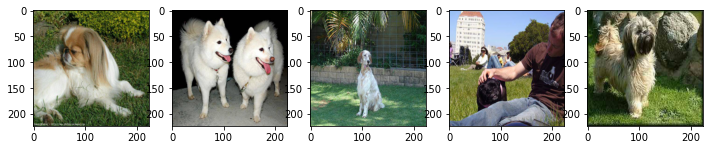

In [13]:
f = plt.figure(figsize=(12,6))
for i, x in enumerate(images[:5]):
    f.add_subplot(1, 5, i + 1)
    plt.imshow(Image.open(x).resize((224,224)))

In [14]:
def run_test(model, loader):
    preds = []
    log_preds = []
    model.eval()
    start_time = time.time()
    print('Running on test set')
    for x, _ in loader:
        with torch.no_grad():
            x_var = x.cuda()

            scores = model(x_var).cpu()
            log_preds += scores.tolist()
            _, _preds = scores.data.max(1)
            preds += _preds.tolist()
    print('Duration = %s' % timedelta(seconds=time.time() - start_time))
    return log_preds, preds

In [15]:
log_preds, preds = run_test(model, test_loader)
results = zip(images, [classes[p] for p in preds])

Running on test set
Duration = 0:02:46.097069


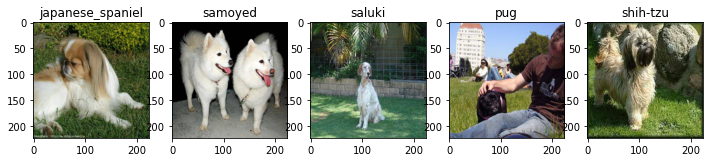

In [16]:
f = plt.figure(figsize=(12,6))
for i, (x, y) in enumerate(itertools.islice(results, 5)):
    f.add_subplot(1, 5, i + 1)
    plt.imshow(Image.open(x).resize((224,224)))
    plt.title(y)

### [Create Submission file for Kaggle](https://youtu.be/9C06ZPF8Uuc?t=32m45s)

In [17]:
probs = np.exp(log_preds)

In [18]:
probs.shape

(10357, 120)

In [19]:
df = pd.DataFrame(probs)

df.columns = classes

df.insert(0, 'id', images_id)

In [20]:
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,1.287880e+04,4.044370e-07,1.726537e-57,8.811607e-55,2.310348e-31,2.105799e-28,3.299546e-05,3.343866e-43,2.454808e-30,...,1.224259e+01,4.275955e+01,1.033119e-50,7.110534e-17,4.964623e-59,2.914124e-36,4.041951e-32,5.507244e-26,4.357592e-16,1.278481e+08
1,00102ee9d8eb90812350685311fe5890,1.510304e-31,9.306269e-26,6.875169e-25,1.200111e-40,4.236110e-15,6.828513e-40,3.428486e-11,2.387580e-24,2.542684e-44,...,7.381817e-22,2.086953e+00,1.648233e-35,2.073173e-30,9.590251e-28,1.419897e-48,2.889978e-07,4.322391e-25,3.388526e-43,1.437107e-32
2,0012a730dfa437f5f3613fb75efcd4ce,9.423979e-49,7.137120e+08,5.326897e-35,1.725990e-42,1.413643e-20,2.286731e-27,2.648152e-22,1.171642e-50,1.103666e-05,...,5.532533e-41,9.344406e-18,5.543448e-51,1.152305e-07,5.399932e-22,1.120343e-01,1.818409e-37,1.456112e-09,4.600571e-22,1.018000e-33
3,001510bc8570bbeee98c8d80c8a95ec1,3.665331e+01,6.429047e-19,1.534194e-22,2.128670e-22,1.105534e-07,1.482218e-37,3.091129e-11,6.301093e-26,8.869076e-24,...,5.698898e-22,3.371792e-19,2.092964e-33,4.903847e-21,6.655572e-15,6.255719e-60,4.237447e-32,1.074391e-16,4.663015e-36,3.441605e-17
4,001a5f3114548acdefa3d4da05474c2e,5.572663e-03,1.435672e-08,2.194203e-32,1.545658e-19,3.313255e-19,2.063960e-19,3.844458e+02,1.398970e-36,4.936028e-16,...,1.059378e-03,5.900108e-12,2.592133e-36,2.160814e-22,1.124253e-30,9.278485e-32,1.662289e-12,2.549350e-19,8.994709e-05,7.993973e+06


In [21]:
df.to_csv('sub-vgg16.gz', compression='gzip', index=False)